In [1]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import src.utils.helper_functions as helper
import src.utils.normalizing_functions as norm
import src.wrappers.spatial_metrics_calcium_binarized_base as sm
import src.utils.bootstrapped_estimation as bootstrap

from src.data.data_loader import LoadData
from src.data.data_processing import ProcessData
from src.utils import pre_processing_functions as pre_process
import src.data.cell_model_base as cs_model

%matplotlib widget


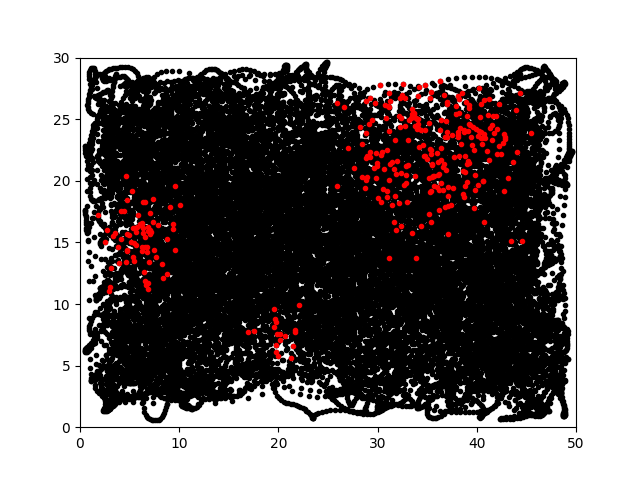

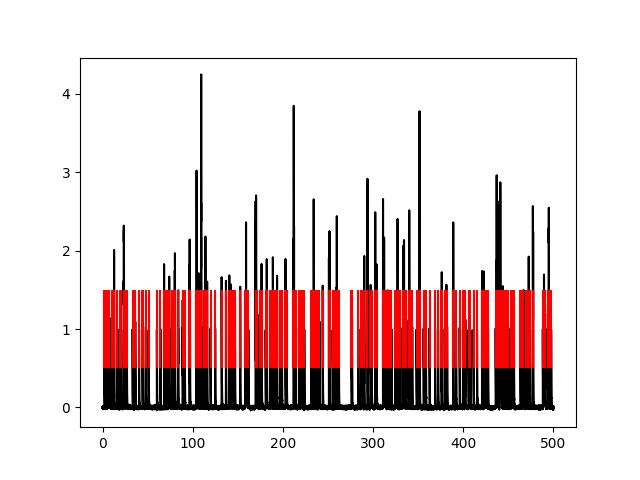

In [2]:

# Cell simulation parameters
sampling_rate = 50. # points/frames per second
duration = 500 # in seconds
rate = 10 # how much your neuron should spike
environment_edges = [[0,50],[0,30]] # in cm [[x_min,x_max],[y_min,y_max]]
smooth_time = 0.1
rho1 = 0.02
sigma = 1
mu_e = 0.

# Define field parameters
num_of_fields = 3

field1_center = (5, 15)
field2_center = (20, 7)
field3_center = (35, 25)
field1_size = 2
field2_size = 1
field3_size = 4

x_coordinates,y_coordinates,speed,speed_smoothed,time_vector = cs_model.generate_random_walk(input_srate = sampling_rate,input_total_Time = duration,heading_srate = 10., speed_srate = 5., rho1  = rho1,sigma = sigma,mu_e  = mu_e, smooth_points = int(np.round(smooth_time*sampling_rate)),environment_edges = environment_edges)
total_points = time_vector.shape[0]

spike_times = cs_model.generate_poisson_spikes(rate, duration)
spike_times_idx = (spike_times*sampling_rate).astype(int)

if num_of_fields == 0:
    modulated_spike_times_idx = spike_times_idx.copy()
else:
    modulated_spike_times_idx = []
    for counter in range(num_of_fields):
        field_center = eval('field' + str(counter+1) + '_center')
        field_size = eval('field' + str(counter+1) + '_size')
        modulated_spike_times_idx_aux = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,spike_times_idx,x_center = field_center[0],y_center = field_center[1], s = field_size)
    
        modulated_spike_times_idx.append(modulated_spike_times_idx_aux)
    modulated_spike_times_idx = np.unique(np.concatenate(modulated_spike_times_idx)).astype(int)
    
signal,time_vector = cs_model.generate_calcium_signal(modulated_spike_times_idx,total_points,sampling_rate,noise_level = 0.01, b = 5.)
peaks_idx = helper.detect_peaks(signal,mpd=0.5*sampling_rate,mph=1.*np.nanstd(signal))


plt.close('all')
plt.figure()
plt.plot(x_coordinates, y_coordinates,'k.')
if len(modulated_spike_times_idx) > 0:
    plt.plot(x_coordinates[modulated_spike_times_idx],y_coordinates[modulated_spike_times_idx],color = 'red',linestyle='',marker='.',markersize=6)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal', 'box')
plt.show()

plt.figure()
plt.plot(time_vector, signal,'k')
if len(modulated_spike_times_idx) > 0:
    plt.eventplot(time_vector[modulated_spike_times_idx],color='red')
plt.show()


In [3]:
# Pre-process signal

signal_type = 'binary'
# 'raw' - Return the original, unprocessed signal.
# 'filtered' - Apply a low-pass filter (cutoff at 2 Hz) to extract the slow components of the signal.
# 'diff' - Compute the first derivative (rate of change) of the low-pass filtered signal.
# 'diff_truncated' - Compute the first derivative of the filtered signal and truncate all negative values (i.e., keep only rising edges).
# 'binary' - Apply low-pass filtering and z-score normalization, then binarize the signal (0`s and 1`s) by thresholding and 
# detecting positive-going changes. This version highlights periods of rising activity above a z-threshold.

normalized_signal = norm.z_score_norm(signal)
binary_signal = pre_process.preprocess_signal(normalized_signal, sampling_rate, signal_type, z_threshold = 1)


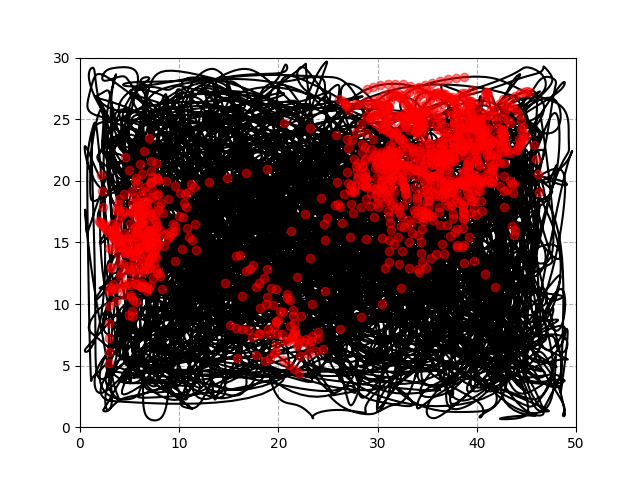

In [4]:
# And test it

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',zorder = 5)
plt.scatter(x_coordinates[binary_signal==1],y_coordinates[binary_signal==1],color = 'red', alpha=0.5, zorder = 10)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.grid(ls='--',zorder = 1)
plt.show()


In [16]:
# These parameters were taken from the paper 
# "Hippocampal Place Fields Maintain a Coherent and Flexible Map across Long Timescales"

# Create a dictionary to hold input parameters for further processing
input_dict = {

# Construct the filename and other identifiers for saving the results
'saving_string' : 'SpatialMetrics.' + signal_type,  # Filename prefix for saved results
'animal_id' : 'NeuronModel',  # Identifier for the animal or model
'dataset' : 'Simulation',  # Name of the dataset
'day' : 1,  # Day or session number
'neuron' : 1,  # Neuron identifier
'trial' : None,  # Trial identifier (optional, can be None)
'saving_path' : None,  # Directory path for saving results (optional, can be None)
'saving' : False,  # Flag indicating whether to save the results (False means no saving)
'overwrite': False, # Flag indicating whether to overwrite already saved file 
'signal_type' : signal_type,  # This is used to detect events. You can use any name for continuous data or "binary".
    
# Set inclusion criteria for the analysis
# Kinky used 50 ms minimum occupancy 
'min_time_spent' : 0.05,  # Minimum time an animal must spend in each xy bin in time_vector units (usually, in seconds)
'min_visits' : 0,  # Minimum number of visits required in each xy bin
'min_speed_threshold' : 1,  # Minimum speed threshold (in coordinate units [e.g., cm, pixels])
'speed_smoothing_sigma' : 0.5,  # Std of the gaussian smooth. Units is the same as time vector (seconds, for instance)

# Set parameters for plotting and information score from map
'x_bin_size' : 1,  # Size of x bins (in coordinate units [e.g., cm, pixels])
'y_bin_size' : 1,  # Size of y bins (in coordinate units [e.g., cm, pixels])
'map_smoothing_sigma_x' : 2.5,  # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps
'map_smoothing_sigma_y' : 2.5, # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps

# Set parameters for information calculation
'x_bin_size_info' : 4,  # Size of x bins (in coordinate units [e.g., cm, pixels])
'y_bin_size_info' : 4,  # Size of y bins (in coordinate units [e.g., cm, pixels])

# Set parameters for surrogate analysis
'shift_time' : 20,  # Time shift window in seconds for creating surrogate distributions
'num_cores' : -1,  # Number of CPU cores to use (set to -1 to use all available cores)
'num_surrogates' : 800,  # Number of surrogate distributions to generate

# Set parameters for place fields detection
'min_num_of_bins' : 1,  # Minimum number of spatial bins required to define a place field
'threshold': ('percentile',50),  # Method and value for detecting significant bins (e.g., 50th percentile of surrogates). 
# Options: ('mean_std',std deviations) or ('percentile',percentile)

# Set parameters for place fields extension
'threshold_fraction': 0.5, # fraction of the peak activity within each field to define the place field extension

'alpha' : 0.05  # Significance level for determining if a neuron is a place cell

}

signal_data = ProcessData(binary_signal, x_coordinates, y_coordinates, time_vector, sampling_rate, environment_edges)

spatial_metrics = sm.PlaceCellBinarized(**input_dict)
spatial_metrics_output = spatial_metrics.main(signal_data)


Processing Surrogates:   0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

SpatialMetrics.binary.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


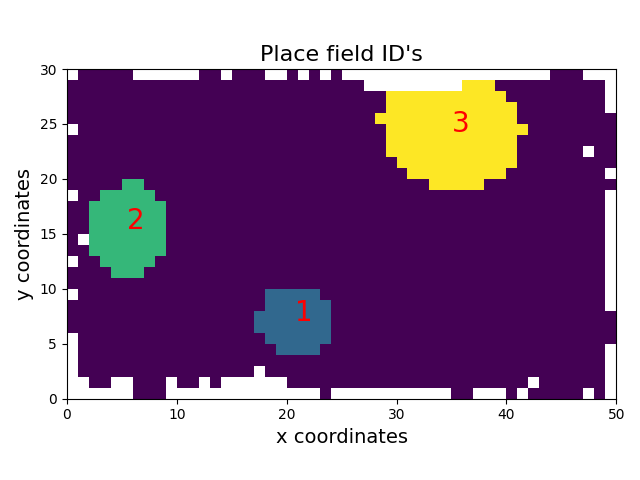

In [17]:

place_cells_x_center_coord = spatial_metrics_output['fields_x_max']
place_cells_y_center_coord = spatial_metrics_output['fields_y_max']

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_identity'])
if spatial_metrics_output['num_of_fields'] > 0:
    for x, y,field_id in zip(place_cells_x_center_coord, place_cells_y_center_coord, spatial_metrics_output['field_ids']):
        plt.text(x, y, str(field_id), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])
plt.gca().set_aspect('equal')  # optional: equal aspect ratio for x/y

plt.tight_layout()
plt.show()


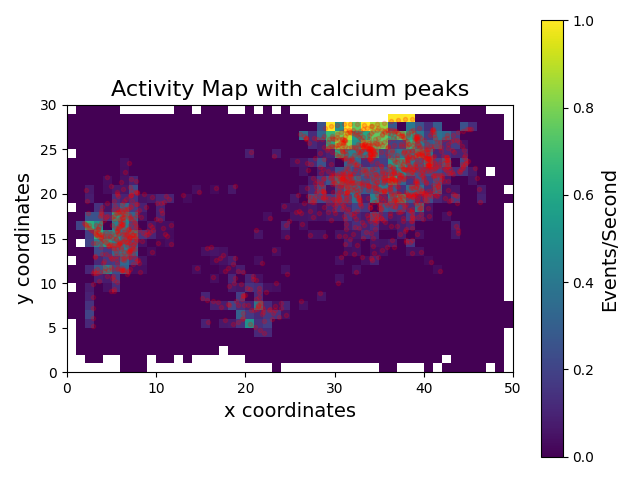

In [18]:

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map'],edgecolors=None)
colorbar = plt.colorbar()
colorbar.set_label('Events/Second',fontsize=14)

plt.plot(spatial_metrics_output['peaks_x_location'],spatial_metrics_output['peaks_y_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)

plt.title('Activity Map with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])
plt.gca().set_aspect('equal')  # optional: equal aspect ratio for x/y
plt.tight_layout()
plt.show()


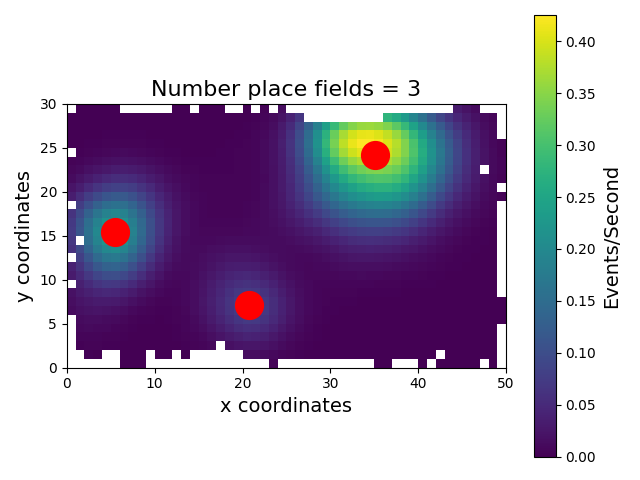

In [19]:
place_cells_x_center_coord = spatial_metrics_output['fields_x_max']
place_cells_y_center_coord = spatial_metrics_output['fields_y_max']

nan_mask = np.isnan(spatial_metrics_output['activity_map'])
activity_map_smoothed = spatial_metrics_output['activity_map_smoothed'].copy()
activity_map_smoothed[nan_mask] = np.nan

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],activity_map_smoothed)
colorbar = plt.colorbar()
colorbar.set_label('Events/Second',fontsize=14)

plt.plot(place_cells_x_center_coord,place_cells_y_center_coord,'r.',markersize=40)

plt.title('Number place fields = {0}'.format(spatial_metrics_output['num_of_fields']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])
plt.gca().set_aspect('equal')  # optional: equal aspect ratio for x/y

plt.tight_layout()
plt.show()


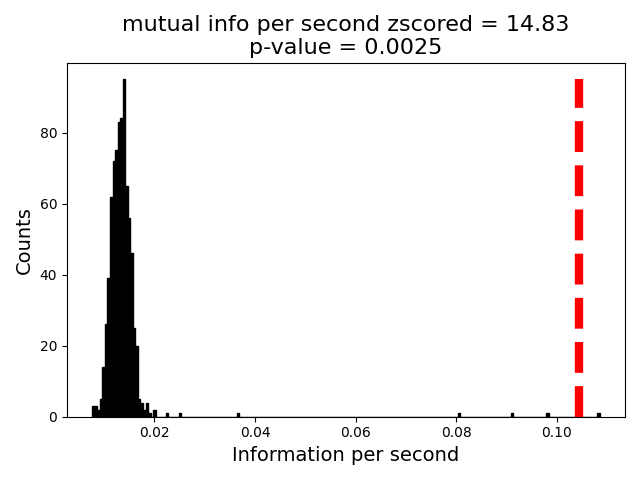

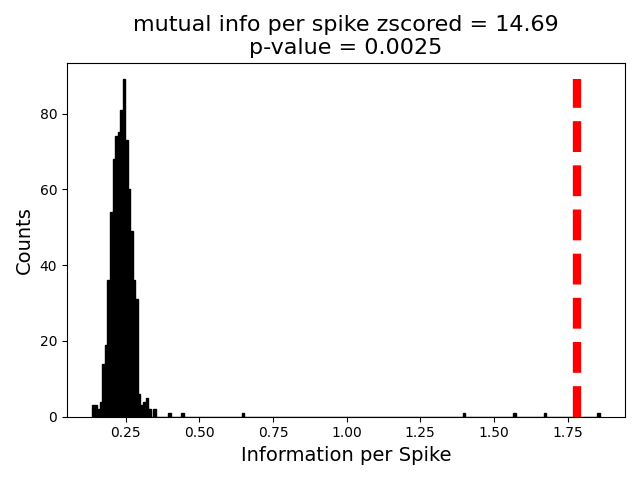

In [20]:

p_value = spatial_metrics_output['mutual_info_per_second_pvalue']
counts,bins = np.histogram(spatial_metrics_output['mutual_info_per_second_shifted'],200)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([spatial_metrics_output['mutual_info_per_second_original'],spatial_metrics_output['mutual_info_per_second_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("mutual info per second zscored = {0:.2f}\np-value = {1:.4f}".format(spatial_metrics_output['mutual_info_per_second_zscored'],p_value),fontsize=16)
plt.xlabel('Information per second',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()



p_value = spatial_metrics_output['mutual_info_per_spike_pvalue']
counts,bins = np.histogram(spatial_metrics_output['mutual_info_per_spike_shifted'],200)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([spatial_metrics_output['mutual_info_per_spike_original'],spatial_metrics_output['mutual_info_per_spike_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("mutual info per spike zscored = {0:.2f}\np-value = {1:.4f}".format(spatial_metrics_output['mutual_info_per_spike_zscored'],p_value),fontsize=16)
plt.xlabel('Information per Spike',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()
